In [1]:
%cd vanhateren_iml

/Users/peterbaumbacher/Dropbox/Cal/2018 - Fall/vs265/proj/ICA_Comparison/vanhateren_iml


In [53]:
import numpy as np
import array 
import sklearn
import scipy as sp
from sklearn.feature_extraction import image
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt

patch_size  = 8
p_per_image = 200
n_images    = 9
r_dim = 40

In [43]:
def plotDataTiled(data, title="", prevFig=None):
  """
    Create a matplotlib plot that displays data as subplots
    Inputs:
      data [np.ndarray] 2-D array of dims (numPixels, batchSize)
        It is assumed that numPixels has an even square root
      title [str] optional string to set as the figure title
  """
  if len(data.shape) == 2:
    (numPixels, batchSize) = data.shape
  elif len(data.shape) == 1:
    numPixels = data.shape
    batchSize = 1
    data = data[:,None]
  else:
    assert 0, ("len(data.shape) should = 2 or 1")
  assert numPixels%np.sqrt(numPixels) == 0, (
        "data.shape[0]  must have an even square root")
  pixelEdgeSize = int(np.sqrt(numPixels))
  subplotEdgeSize = int(np.ceil(np.sqrt(batchSize)))
  if prevFig is not None:
    (fig, subAxes, axisImage) = prevFig
  else:
    fig, subAxes = plt.subplots(nrows=subplotEdgeSize, ncols=subplotEdgeSize)
    axisImage = [None]*len(fig.axes)
  for axisIndex, axis in enumerate(fig.axes):
    if axisIndex < batchSize:
      image = data[:,axisIndex].reshape(pixelEdgeSize, pixelEdgeSize)
      if prevFig is not None:
        axisImage[axisIndex].set_data(image)
      else:
        axisImage[axisIndex] = axis.imshow(image, cmap="Greys",
          interpolation="nearest")
        axis.tick_params(
          axis="both",
          bottom="off",
          top="off",
          left="off",
          right="off")
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    else:
      for spine in axis.spines.values():
        spine.set_visible(False)
      axis.tick_params(
        axis="both",
        bottom="off",
        top="off",
        left="off",
        right="off")
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
  fig.suptitle(title)
  if prevFig is not None:
    fig.canvas.draw()
  else:
    fig.show()
  return (fig, subAxes, axisImage)

In [50]:
# load a set of 9 images 
images  = []
patches = []
for i in range(n_images):
    filename  = 'imk0000'
    filename += str(i + 1)
    filename += '.iml'
    
    with open(filename, 'rb') as handle:
        s = handle.read()
    arr   = array.array('H', s)
    arr.byteswap()
    # img   = np.array(arr, dtype='uint16').reshape(1024, 1536)
    img   = np.array(arr, dtype='uint16').reshape(1024 * 1536)
    
    # set image to zero mean and unit variance
    img   = (img - np.mean(img)) / np.std(img)
    
    images.append(img)

images  = np.array(images)
print(images.shape)
images = images
#pca = PCA(whiten=True)
#images = pca.fit_transform(images)
    
for img in images:
    img = img.reshape(1024, 1536)
    # extract image patches, set patches to zero mean
    patch = image.extract_patches_2d(img, [patch_size, patch_size], max_patches = p_per_image)
    for i in range(patch.shape[0]):
        # patch[i] = patch[i] - np.mean(patch[i])
        pass

    patches.append(patch)

patches = np.array(patches)
patches = patches - patches.mean(axis=0)

# reshape for convenience 
patches = np.reshape(patches, [n_images*p_per_image, patch_size * patch_size])
print(patches.shape)
pca = PCA(n_components=40, whiten=True)
patches = pca.fit_transform(patches)

(9, 1572864)
(1800, 64)


/Users/peterbaumbacher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(<matplotlib.figure.Figure at 0x12213c198>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1296fcba8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x12a5275c0>]], dtype=object),
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None])

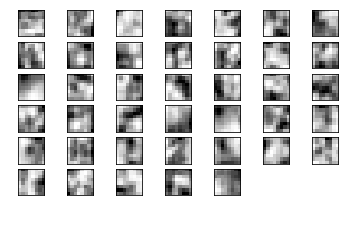

In [55]:
# Use Fast ICA to find independent components of image patches
ica = FastICA(n_components = 40, max_iter=500)
ica.fit_transform(patches)
W   = ica.mixing_

W_vis = W @ np.real( np.linalg.inv(sp.linalg.sqrtm(W.T @ W)) )

W_vis = pca.inverse_transform(W_vis)
# W_vis   = np.reshape(W_vis, [40, 8, 8])

# fig, axs = plt.subplots(8, 8)
# fig.set_size_inches(5,5)

plotDataTiled(W_vis.T)
# for i in range(8):
#     for j in range(8):
#         ax = axs[i, j]
#         ax.imshow(W_vis[i*8 + j], cmap = 'Greys')
#         ax.tick_params(
#           axis="both",
#           bottom="off",
#           top="off",
#           left="off",
#           right="off")
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
